<a href="https://colab.research.google.com/github/TienLungSun/PyTorch-deep-learning/blob/main/3.%20Classification_(new).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.utils.data as Data

In [3]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda Tesla T4


# Upload excel data file to Colab
# Read data file to dataframe --> convert to numpy array

In [4]:
fname = "wine_dataset_classification_practice.xlsx"
df=pd.read_excel(fname)
df.head(3)

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Target
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0


In [5]:
df.columns

Index(['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5',
       'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10',
       'Feature_11', 'Feature_12', 'Feature_13', 'Target'],
      dtype='object')

In [6]:
dfX = df[['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5',
       'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10',
       'Feature_11', 'Feature_12', 'Feature_13']]
dfY = df['Target']

In [7]:
#convert data to numpy array
numpyX = np.array(dfX.values)
numpyY = np.array(dfY.values)
print(numpyX.shape, numpyY.shape)

(178, 13) (178,)


### Split input data to train and test data

In [8]:
trainX, testX, trainY, testY = train_test_split(numpyX, numpyY, test_size=0.20, random_state=0)
print(trainX.shape, testX.shape, trainY.shape, testY.shape)

(142, 13) (36, 13) (142,) (36,)


### Define NN

In [10]:
MyNet = nn.Sequential(
    nn.Linear(13, 128),
    nn.Tanh(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 56),
    nn.Tanh(),
    nn.Dropout(p=0.5),
    nn.Linear(56, 3),
)
MyNet.to(device)

Sequential(
  (0): Linear(in_features=13, out_features=128, bias=True)
  (1): Tanh()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=128, out_features=56, bias=True)
  (4): Tanh()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=56, out_features=3, bias=True)
)

# Train NN

In [11]:
train_lossLst = []
validation_lossLst = []

In [13]:
# split training data to train and validation
trainX, validationX, trainY, validationY = train_test_split(trainX, trainY, test_size=0.20, random_state=0)
tensor_trainX = torch.FloatTensor(trainX).to(device)
tensor_trainY = torch.LongTensor(trainY).to(device)

tensor_validationX = torch.FloatTensor(validationX).to(device)
tensor_validationY = torch.LongTensor(validationY).to(device)

print(tensor_trainX.shape, tensor_trainY.shape, tensor_validationX.shape, tensor_validationY.shape)

torch.Size([90, 13]) torch.Size([90]) torch.Size([23, 13]) torch.Size([23])


In [14]:
# Generate mini-batches of training data
BATCH_SIZE = 16   #try 1/5, 1/10, 1/15 of the training data
torch_dataset = Data.TensorDataset(tensor_trainX, tensor_trainY)
loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

In [15]:
# initialize NN weights
for name, param in MyNet.named_parameters():
  if(param.requires_grad):
    torch.nn.init.normal_(param, mean=0.0, std=0.02)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(MyNet.parameters(), lr=0.0003)

In [16]:
# train NN
epoch_lossLst=[]
for epoch in range(1, 2000):
  if(epoch%200 == 0):
    print(epoch, end=",")
  for (batchX, batchY) in loader:
    batchY_hat = MyNet(batchX)
    loss = loss_func(batchY_hat, batchY)
    epoch_lossLst.append(float(loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  avg = sum(epoch_lossLst) / len(epoch_lossLst)
  train_lossLst.append(avg)

  with torch.no_grad():
      tensor_validationY_hat = MyNet(tensor_validationX)
      tensor_validationY = tensor_validationY.view(-1)
      validatiion_loss = loss_func(tensor_validationY_hat, tensor_validationY)
      validation_lossLst.append(float(validatiion_loss))

200,400,600,800,1000,1200,1400,1600,1800,

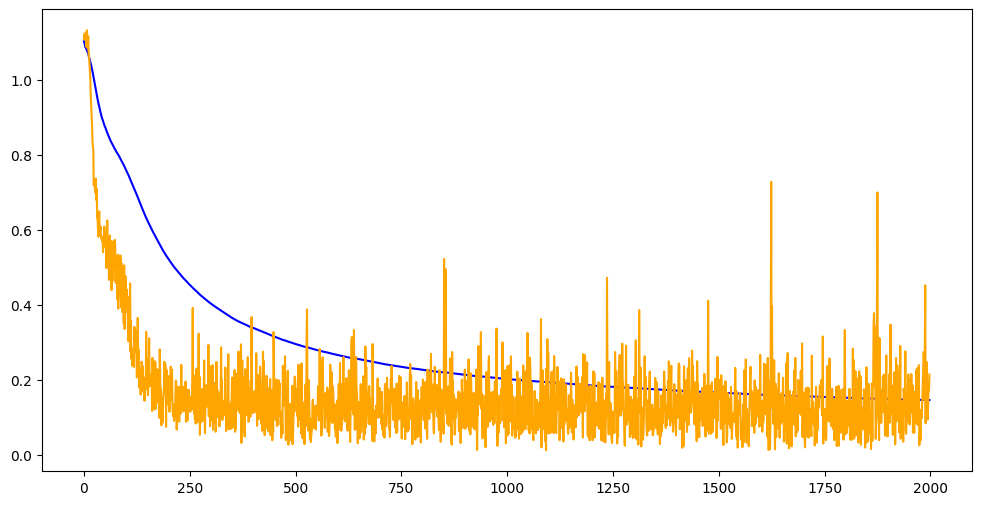

In [17]:
fig=plt.figure(figsize=(12, 6))
plt.plot(train_lossLst, color='blue')
plt.plot(validation_lossLst, color='orange')
plt.show()

In [18]:
# save model of this training
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%m-%d-%H-%M-%S")
print(formatted_time)
fname = formatted_time + ".pth"
torch.save(MyNet.state_dict(), fname)

11-25-03-44-24


### Mannually go back to train again --> observe train, validation loss --> train again...

### After train several times, pick up the best model

In [19]:
# Load the best model
MyNet.load_state_dict(torch.load('11-25-03-44-24.pth'))

<All keys matched successfully>

In [20]:
MyNet.eval()
MyNet.to(device)

Sequential(
  (0): Linear(in_features=13, out_features=128, bias=True)
  (1): Tanh()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=128, out_features=56, bias=True)
  (4): Tanh()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=56, out_features=3, bias=True)
)

In [21]:
# Test to check generalized prediction performance
tensor_testX = torch.FloatTensor(testX).to(device)
tensor_testY = torch.LongTensor(testY).to(device)

In [22]:
tensor_testY_hat = MyNet(tensor_testX)
tensor_testY_hat = torch.softmax(tensor_testY_hat, 1)
MaxIdxOfEachRow = torch.max(tensor_testY_hat, 1)[1]

In [24]:
conf_matrix = confusion_matrix(tensor_testY.cpu().numpy(), MaxIdxOfEachRow.cpu().numpy())

<Axes: >

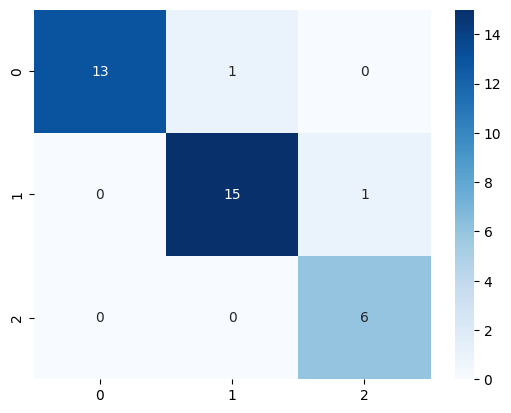

In [25]:
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')